In [1]:
from collections import defaultdict
import json
import pickle
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy import stats
from sklearn.metrics import auc
import sys
    
def interpolate(x, y, x_t):
    y_rev = list(reversed(list(y)))
    x_rev = list(reversed(list(x)))
    return np.interp(x_t, x_rev, y_rev)

def average_same_x(x, y_list):
    n = len(x)
    d = len(y_list)
    out = []
    for i in range(n):
        v = 0.0
        for j in range(d):
            v += y_list[j][i]
        v /= d
        out.append(v)
    return out

In [2]:
modes = {'initial-tune': 'Baseline', 'spire': 'SPIRE', 'fs-3': 'FS'}
trials = [0,1,2,3,4,5,6,7]
baseline = 'initial-tune'
corrected_list = ['spire', 'fs-3']

with open('./0-FindPairs/Pairs.json', 'r') as f:
    pairs = json.load(f)

# Performance on the Original Distribution

In [3]:
out = {}

for mode in modes:

    agg = []
    for trial in trials:

        with open('./2-Models/Models/{}/trial{}/results.pkl'.format(mode, trial), 'rb') as f:
            results = pickle.load(f)
        
        agg.append(results['MAP'])
    out[mode] = np.array(agg)
        
print(modes[baseline])
print(np.round(np.mean(out[baseline]), 4), np.round(np.std(out[baseline]), 4))

for corrected in corrected_list:   
    print(modes[corrected])
    diff = out[corrected] - out[baseline]
    test = stats.ttest_rel(out[corrected], out[baseline])
    print(np.round(np.mean(diff), 4), np.round(np.std(diff), 4), np.round(test.pvalue, 3))
    


Baseline
0.6407 0.0068
SPIRE
-0.0037 0.0009 0.0
FS
-0.0157 0.0102 0.005


# Performance on the Balanced Distribution (averaged across SPs and trials)

In [4]:
ts = np.linspace(0, 1, num = 101)

out = {}
for mode in modes:
    agg = []
    for trial in trials:
        with open('./2-Models/Models/{}/trial{}/results.pkl'.format(mode, trial), 'rb') as f:
            results = pickle.load(f)

        v = 0
        for pair in pairs:
            pr_curve = interpolate(results[pair]['recall'], results[pair]['precision'], ts)
            v += auc(ts, pr_curve) / len(pairs)

        agg.append(v)
    
    out[mode] = np.array(agg)
    
print(modes[baseline])
print(np.round(np.mean(out[baseline]), 4), np.round(np.std(out[baseline]), 4))

for corrected in corrected_list:   
    print(modes[corrected])
    diff = out[corrected] - out[baseline]
    test = stats.ttest_rel(out[corrected], out[baseline])
    print(np.round(np.mean(out[corrected]), 4), np.round(np.mean(diff), 4), np.round(np.std(diff), 4), np.round(test.pvalue, 3))

Baseline
0.4617 0.0126
SPIRE
0.4736 0.0119 0.0049 0.0
FS
0.4469 -0.0148 0.0185 0.073


# Analysis of Individual SPs (average across trials per SP)

cell+phone-person


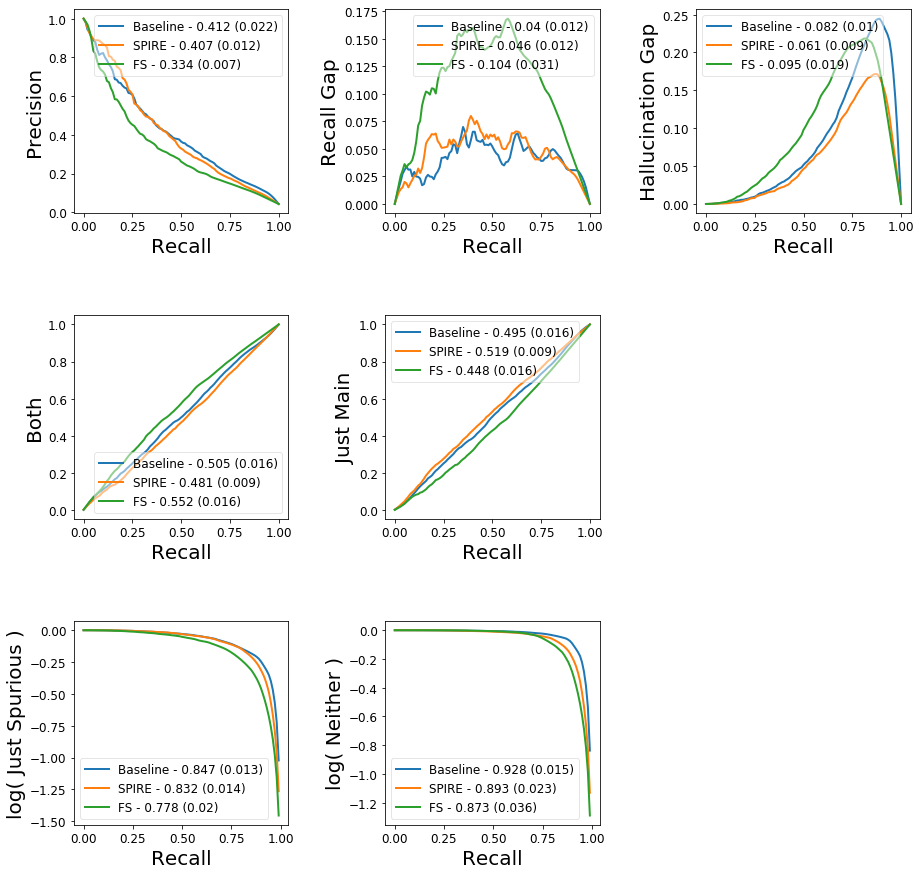

handbag-person


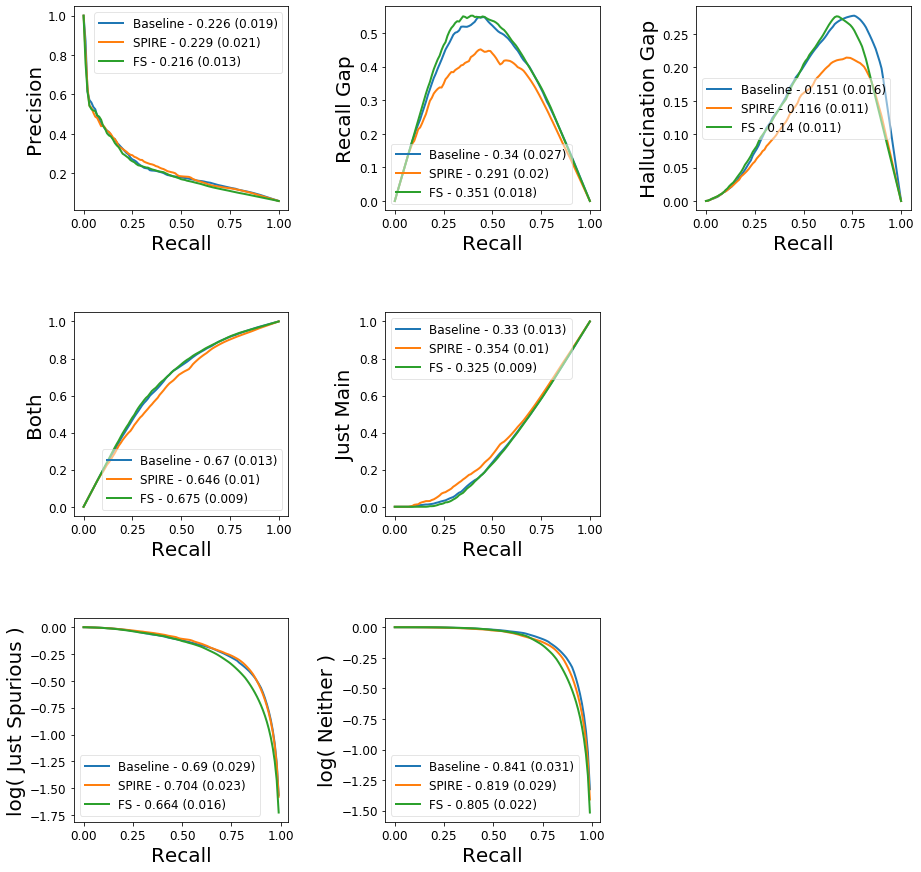

bench-elephant


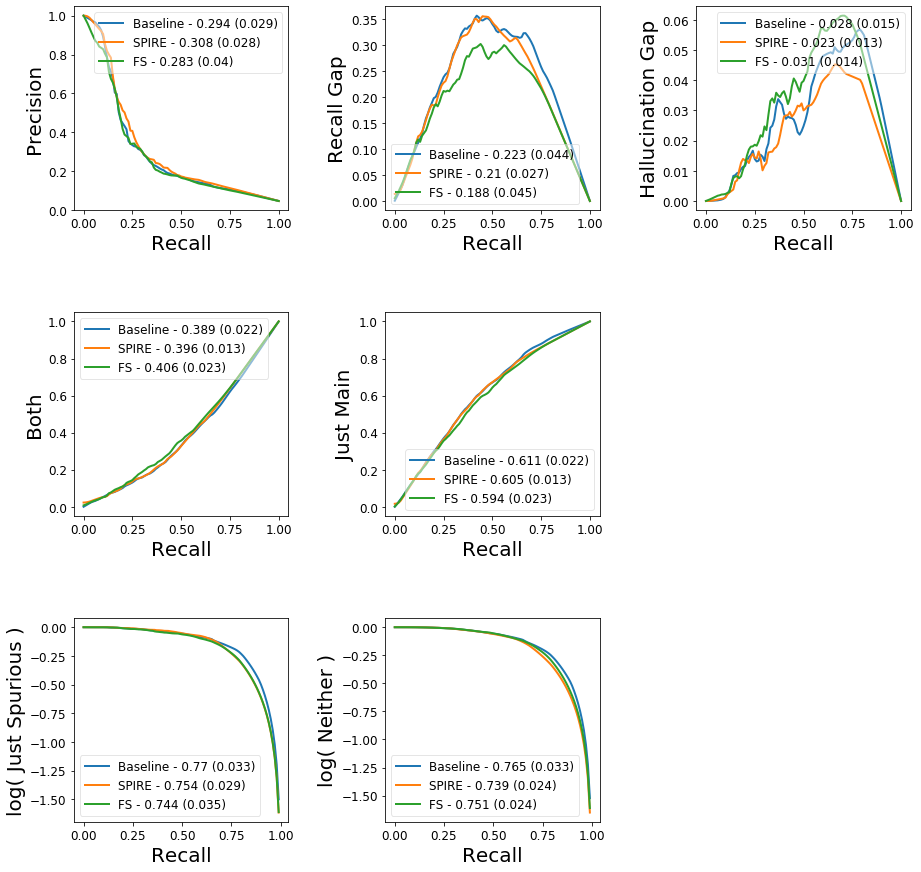

truck-airplane


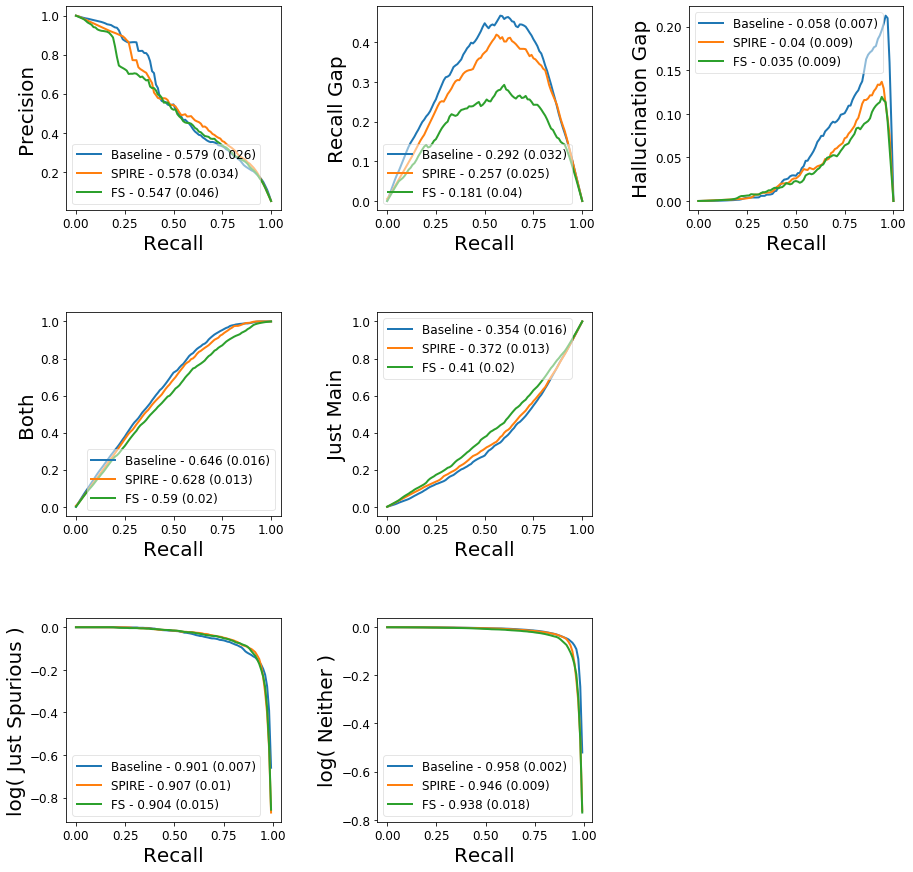

sandwich-dining+table


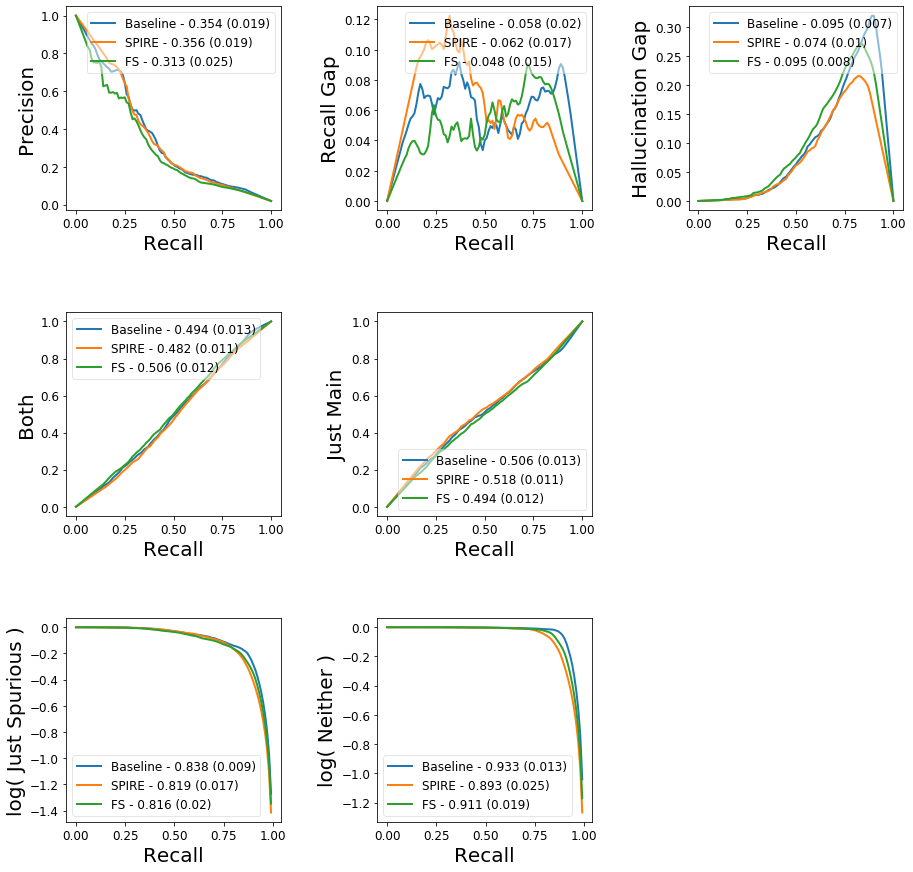

dog-sheep


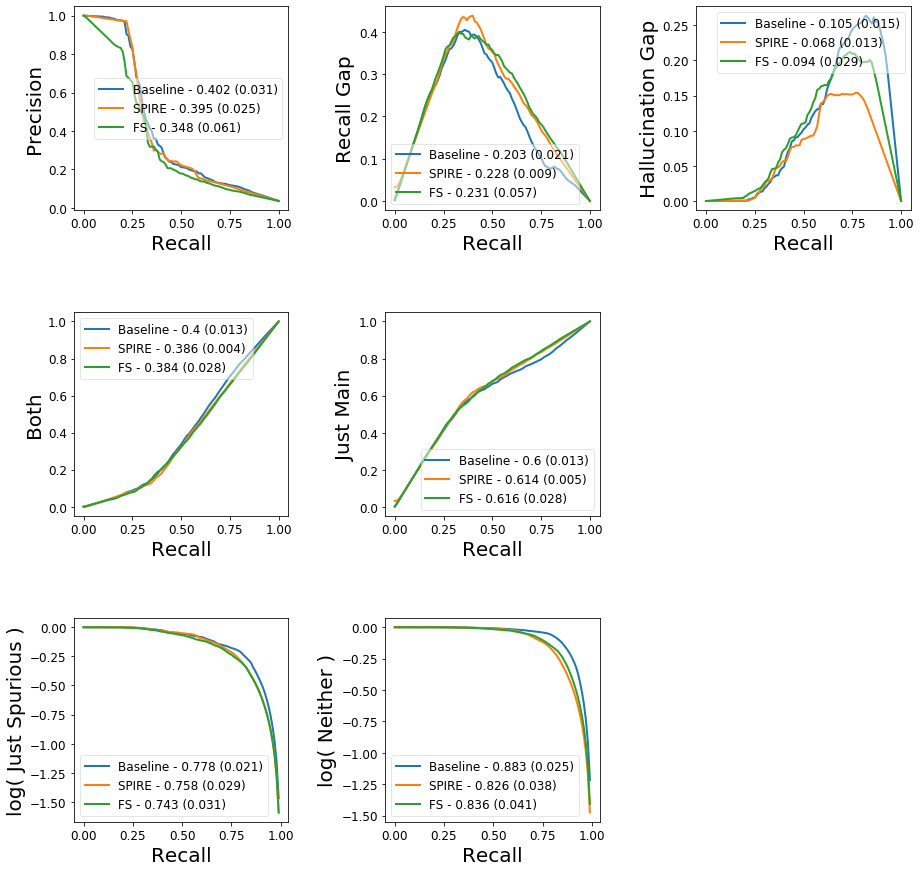

donut-person


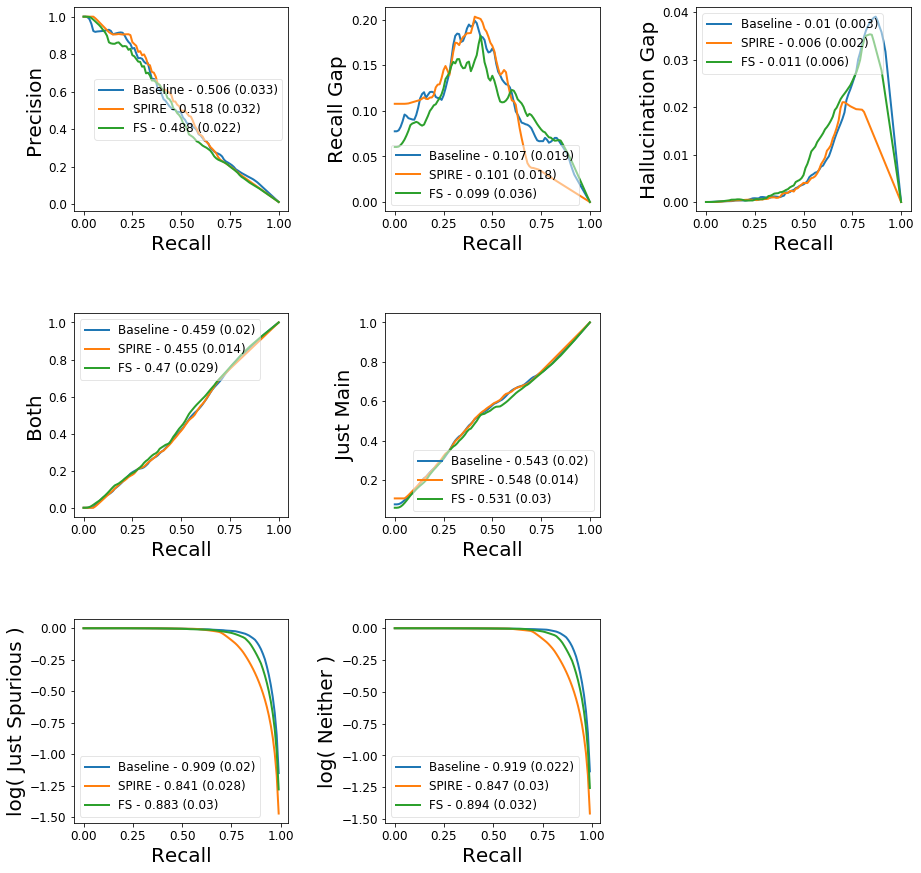

tie-cat


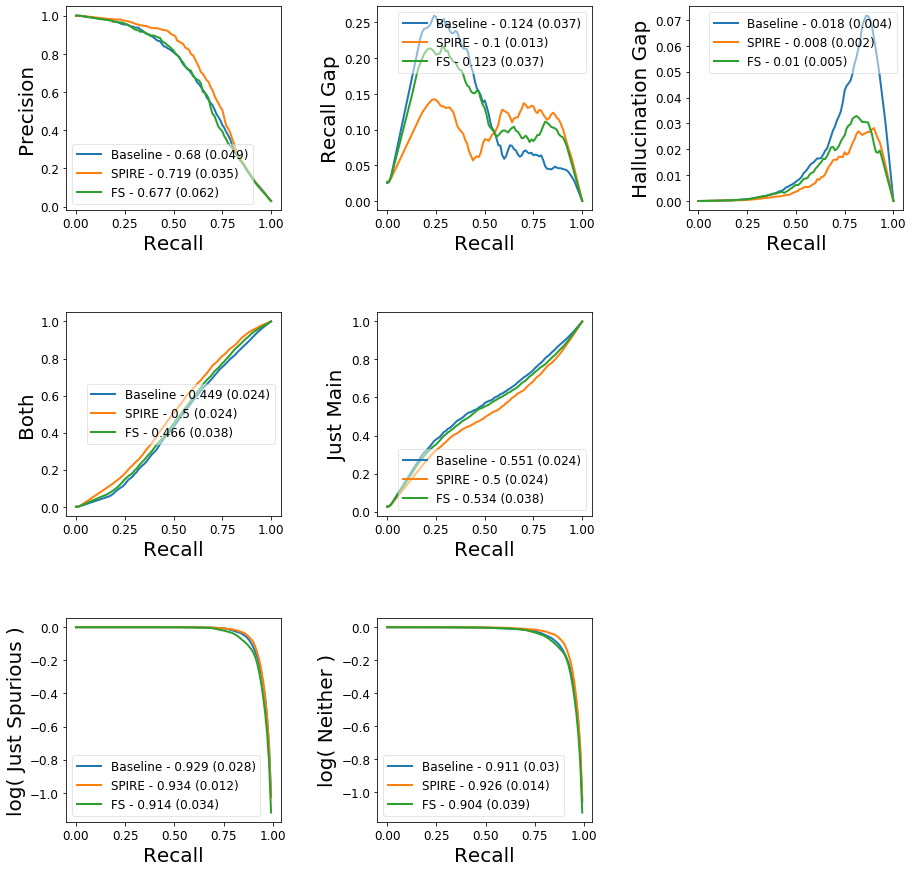

tie-person


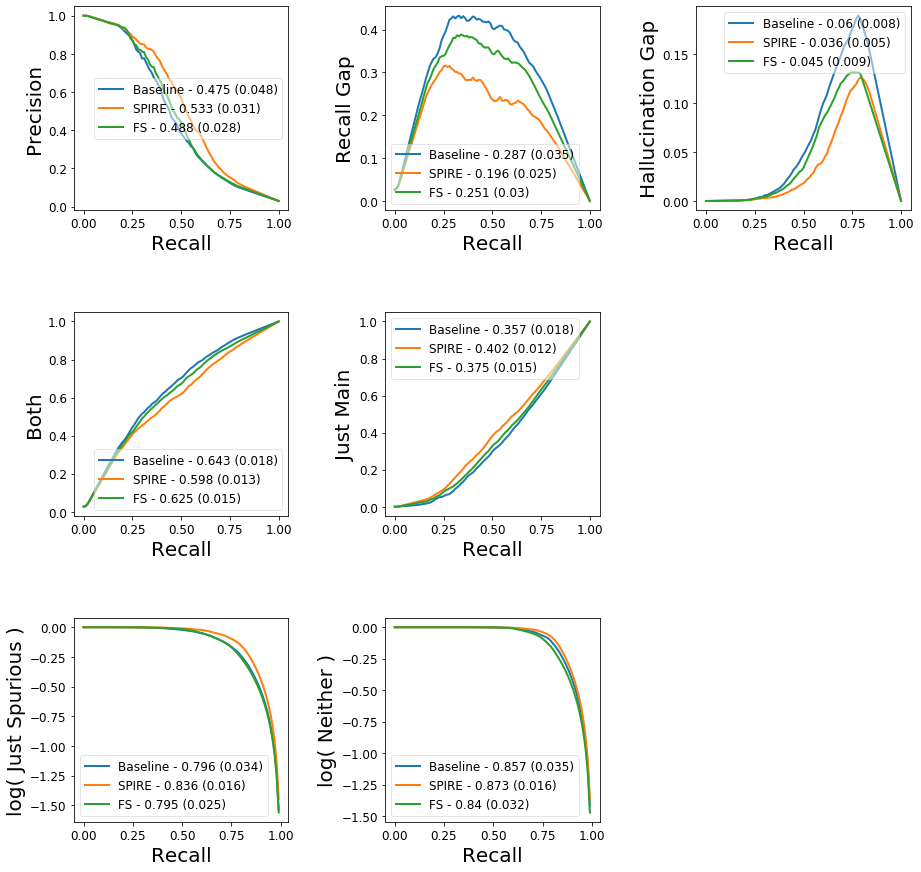

couch-person


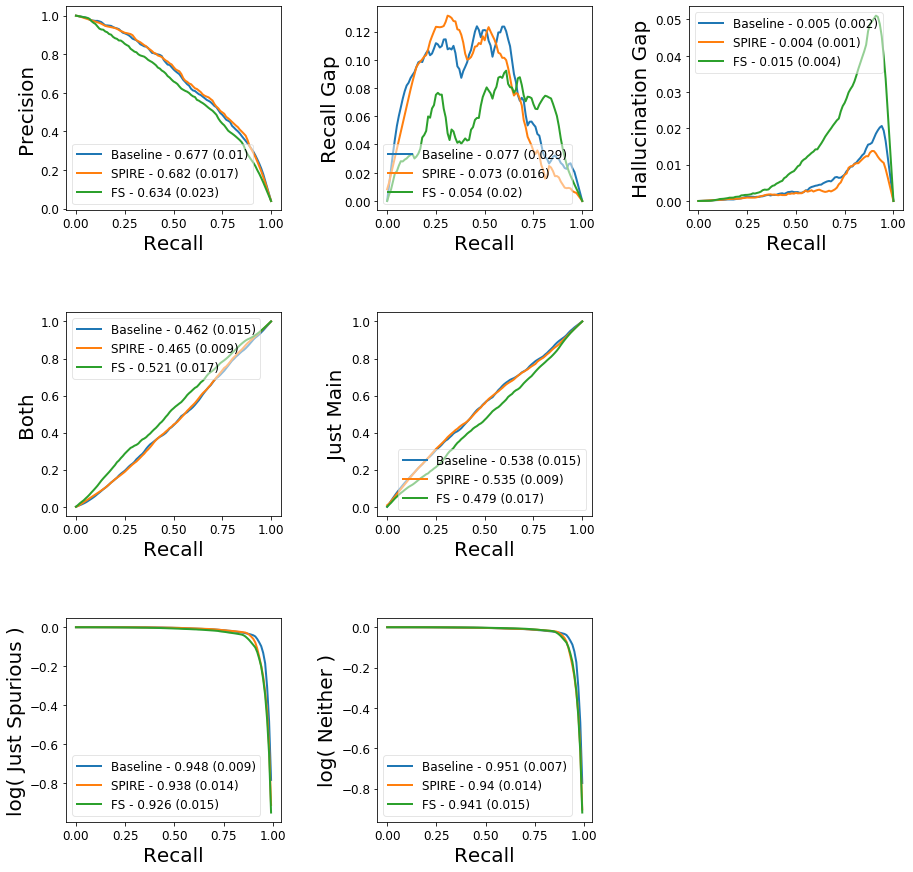

hair+drier-person


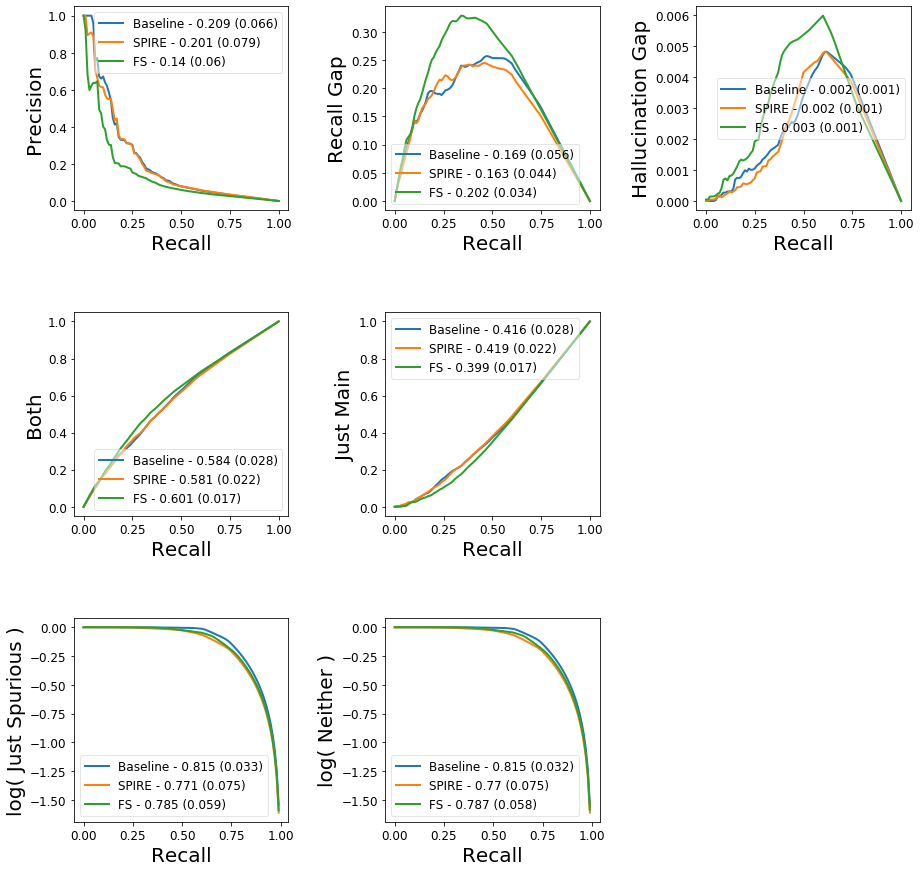

hot+dog-person


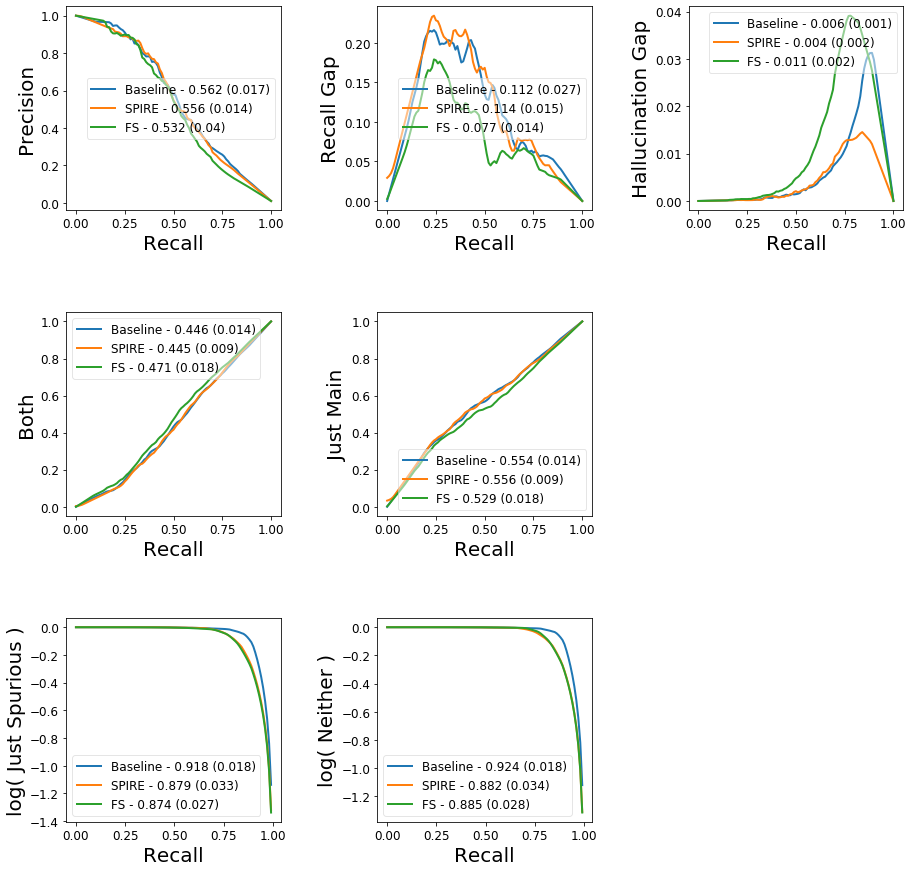

knife-person


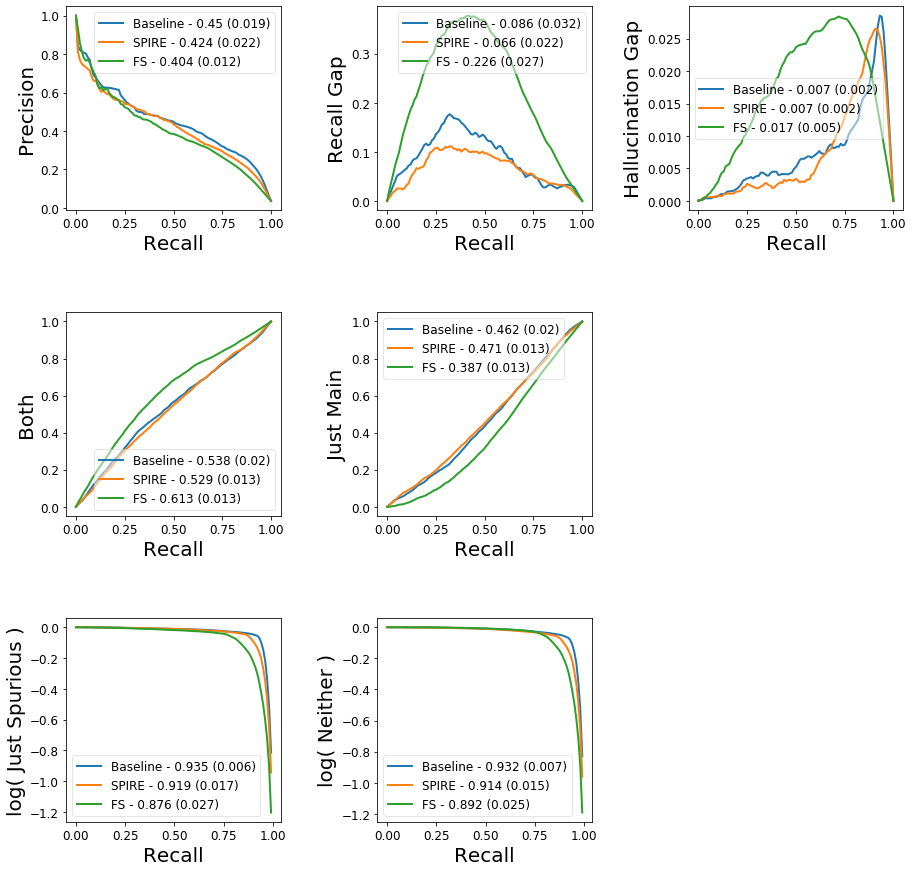

knife-dining+table


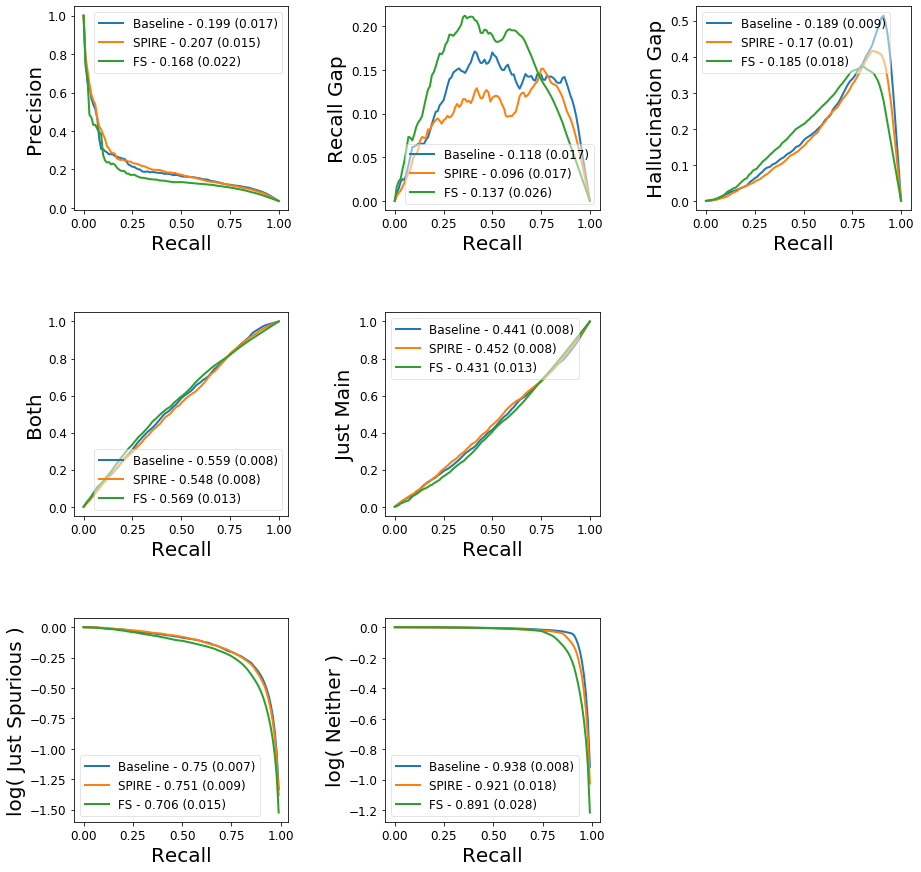

tennis+racket-person

Baseline
0.6450086058519794
both 0.8548
just_main 0.4452
just_spurious 0.9946
neither 0.9999
r-gap 0.4096
h-gap 0.0053
ap 0.8954


SPIRE
0.6171256454388985
both 0.8186
just_main 0.4814
just_spurious 0.9954
neither 0.9994
r-gap 0.3372
h-gap 0.0041
ap 0.8979


FS
0.6299483648881239
both 0.8379
just_main 0.4621
just_spurious 0.9957
neither 0.9999
r-gap 0.3759
h-gap 0.0043
ap 0.9133



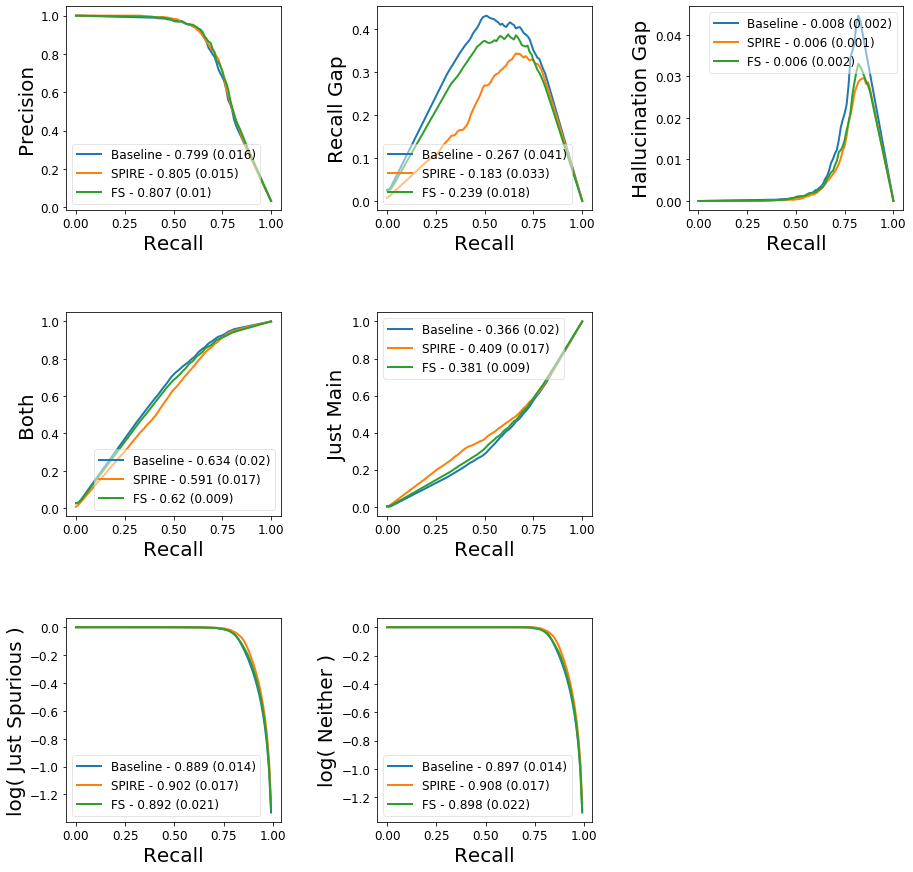

fork-dining+table


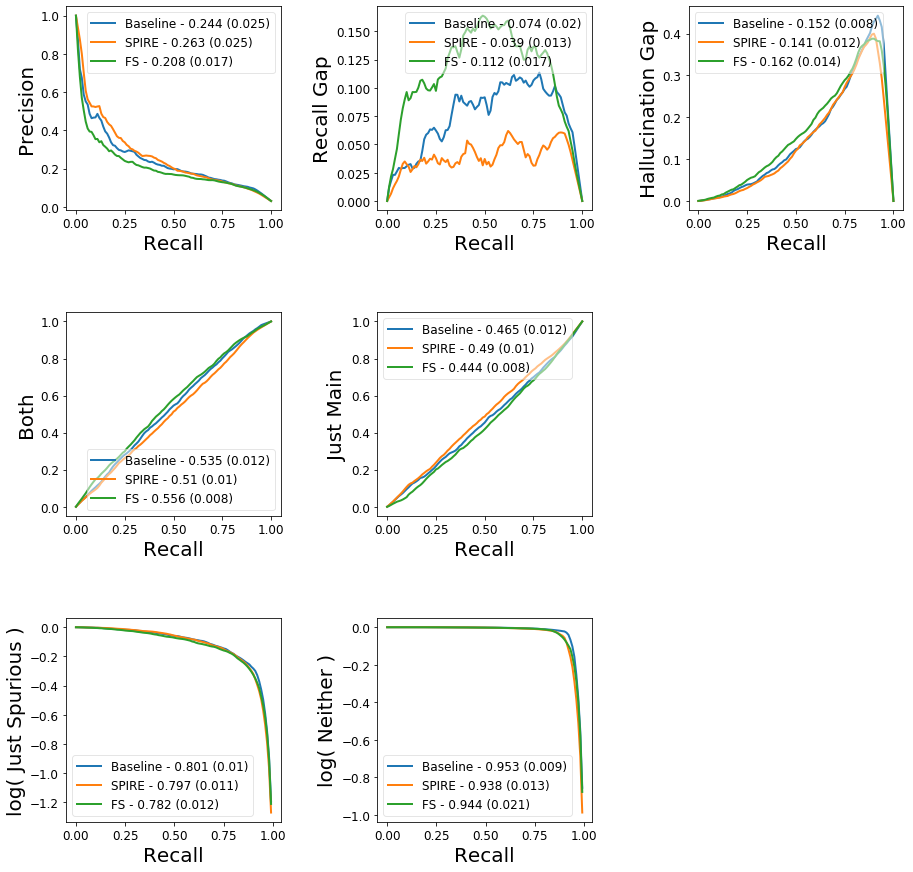

frisbee-person


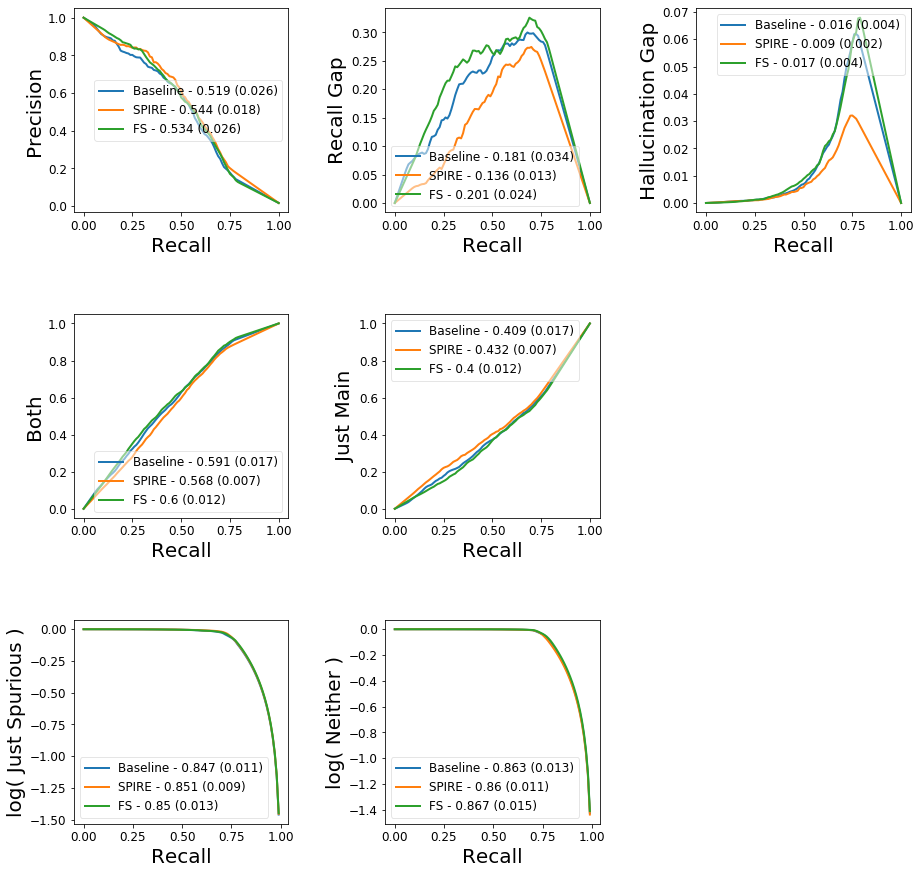

frisbee-dog


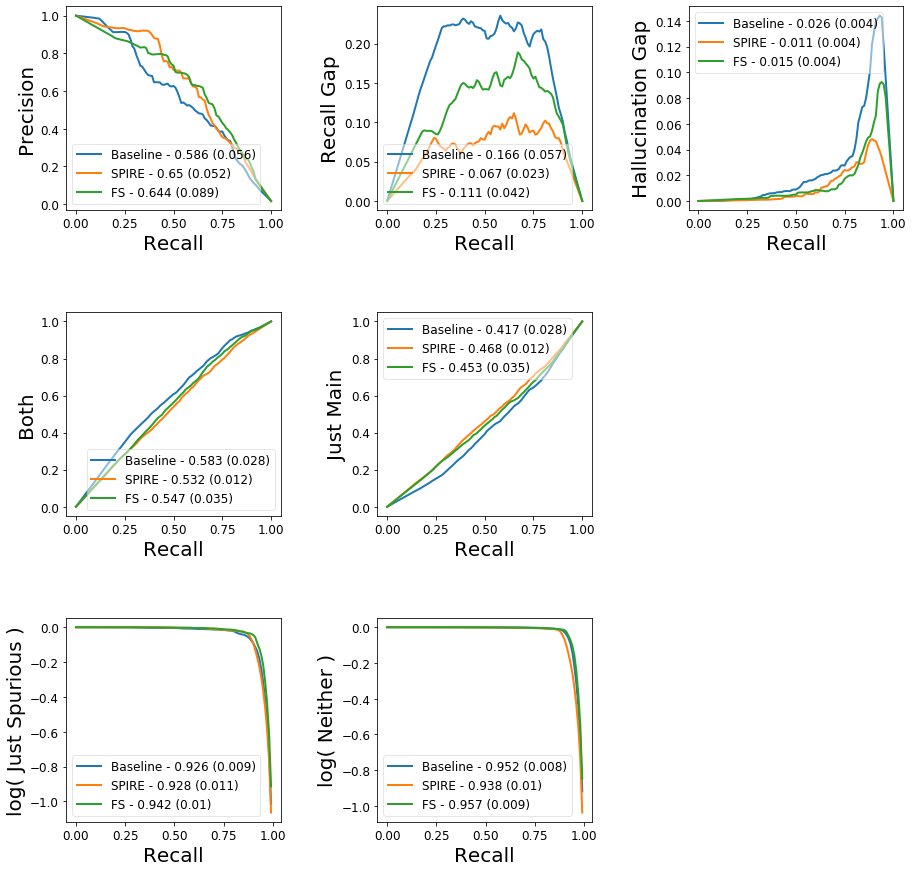

spoon-dining+table


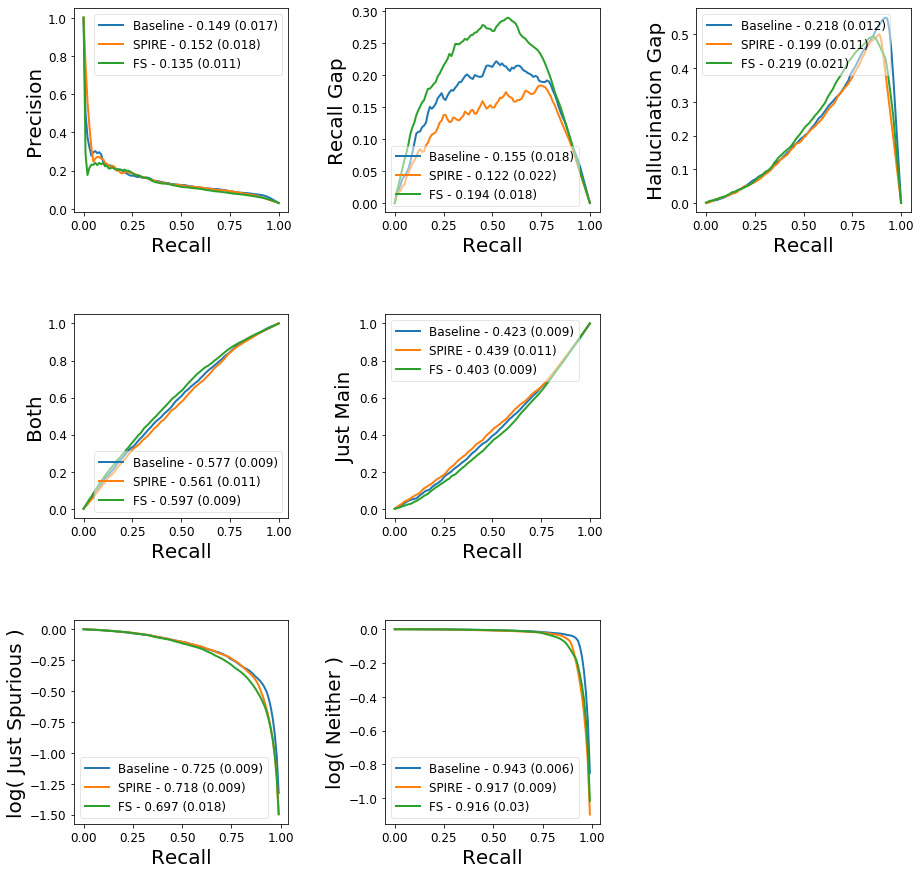

skateboard-person


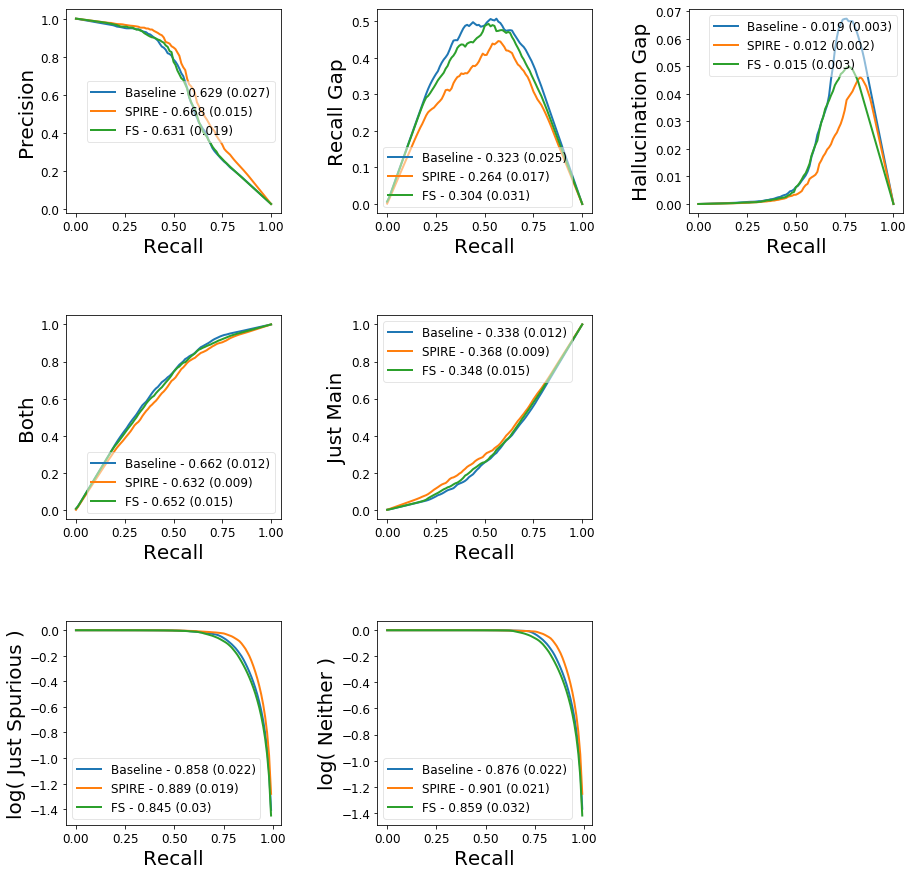

baseball+glove-person


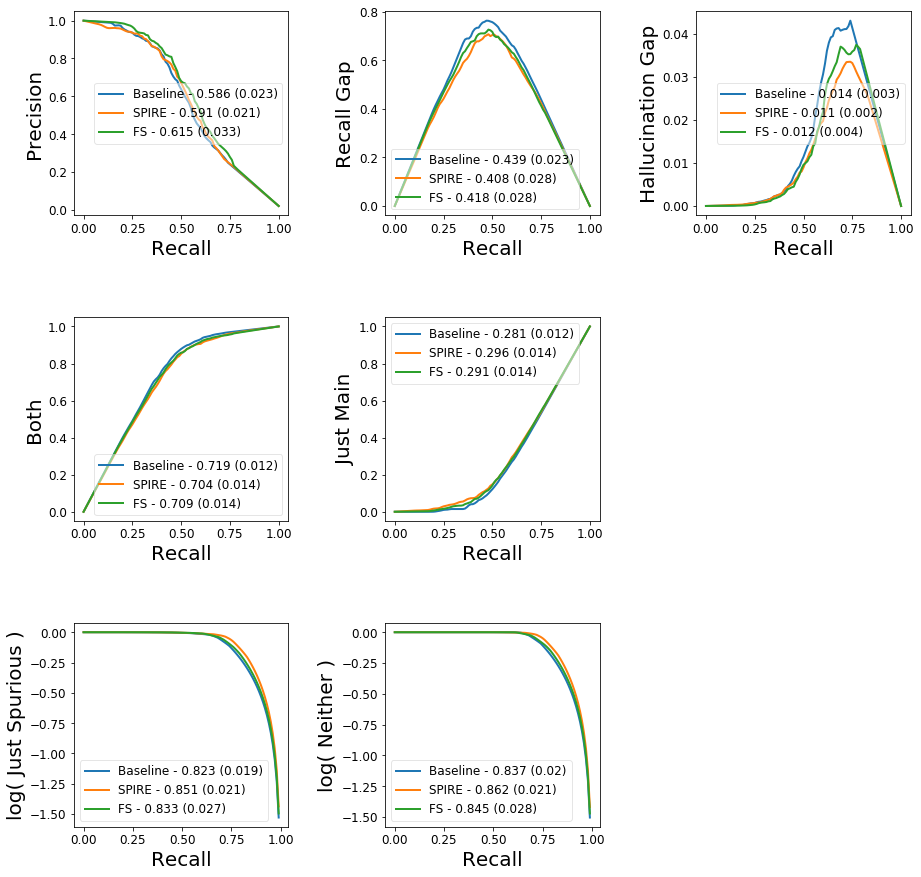

baseball+bat-person


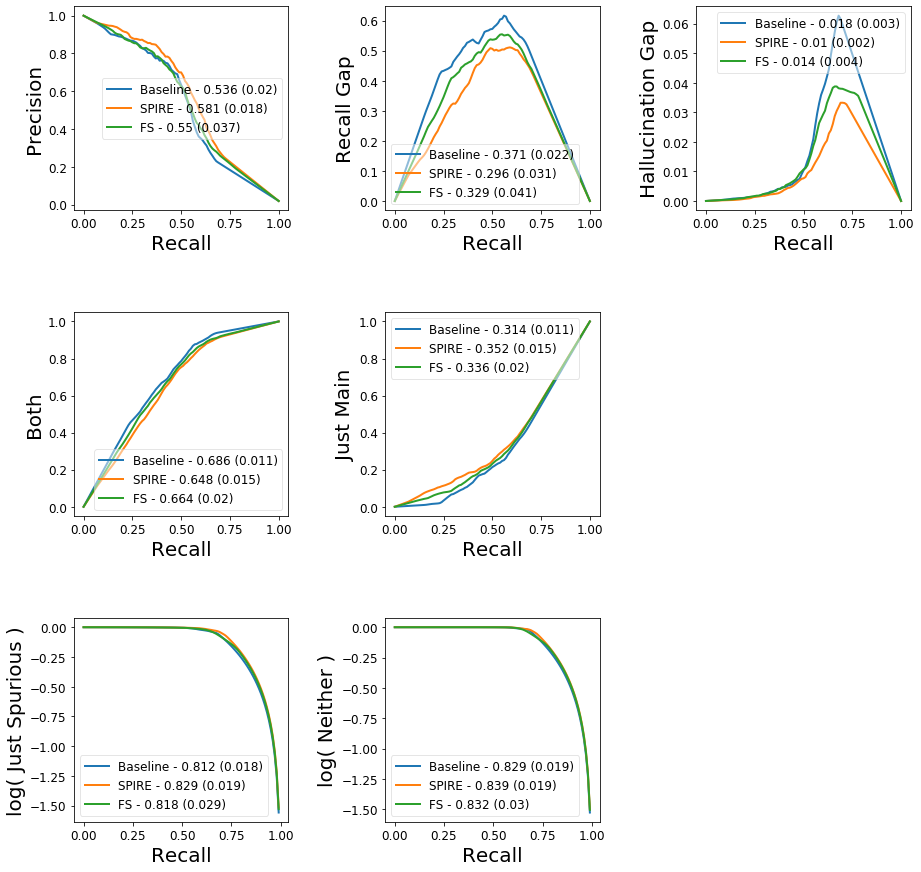

bird-sheep


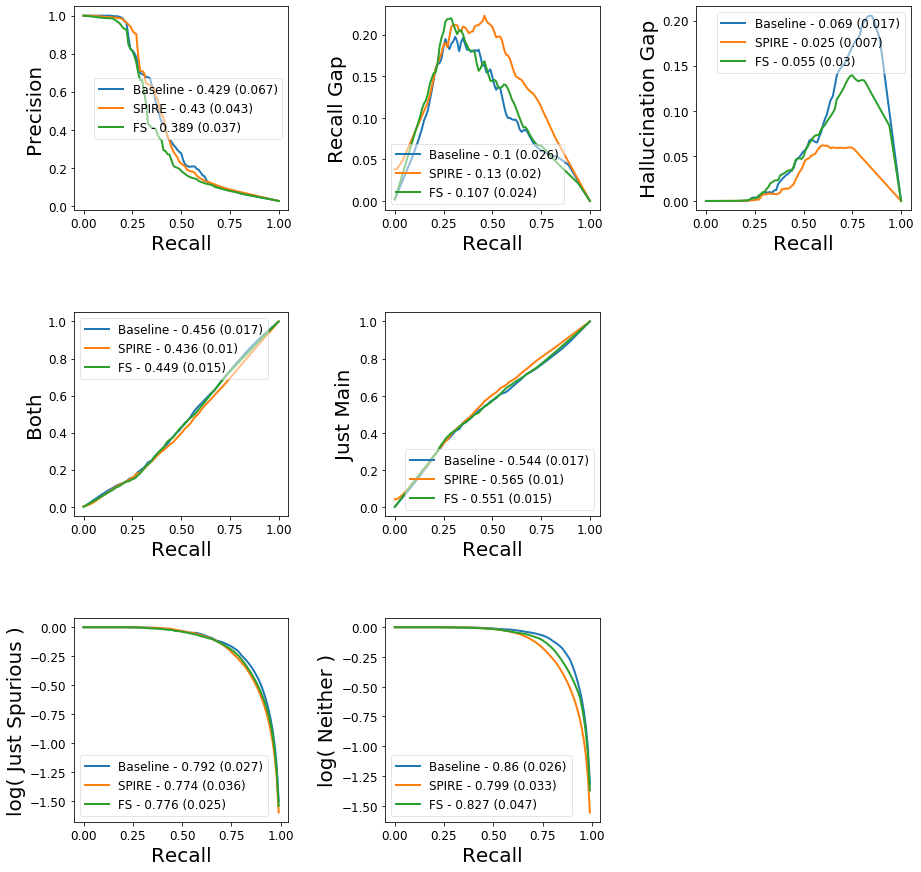

snowboard-person


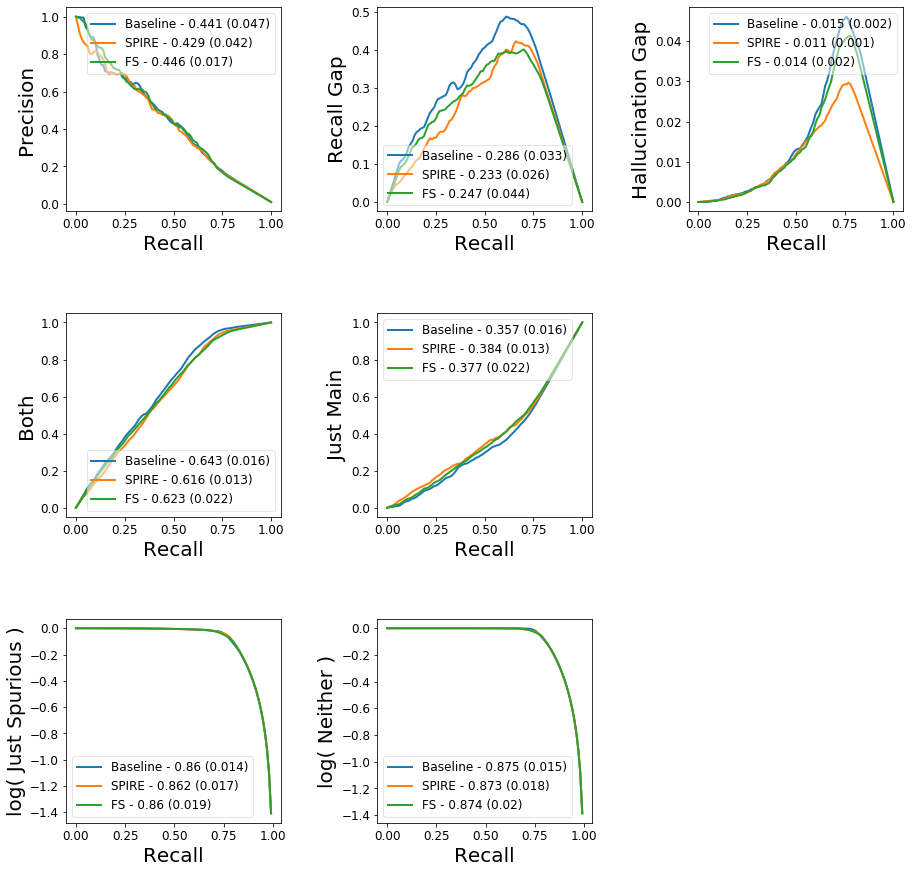

bowl-dining+table


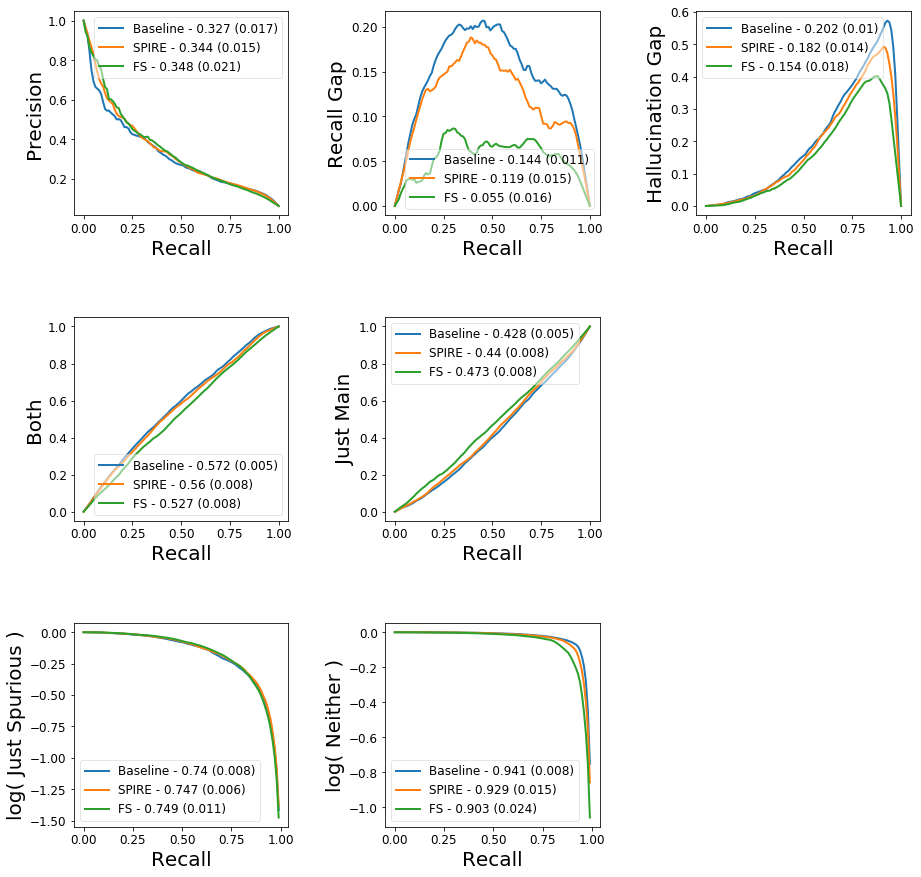

remote-person


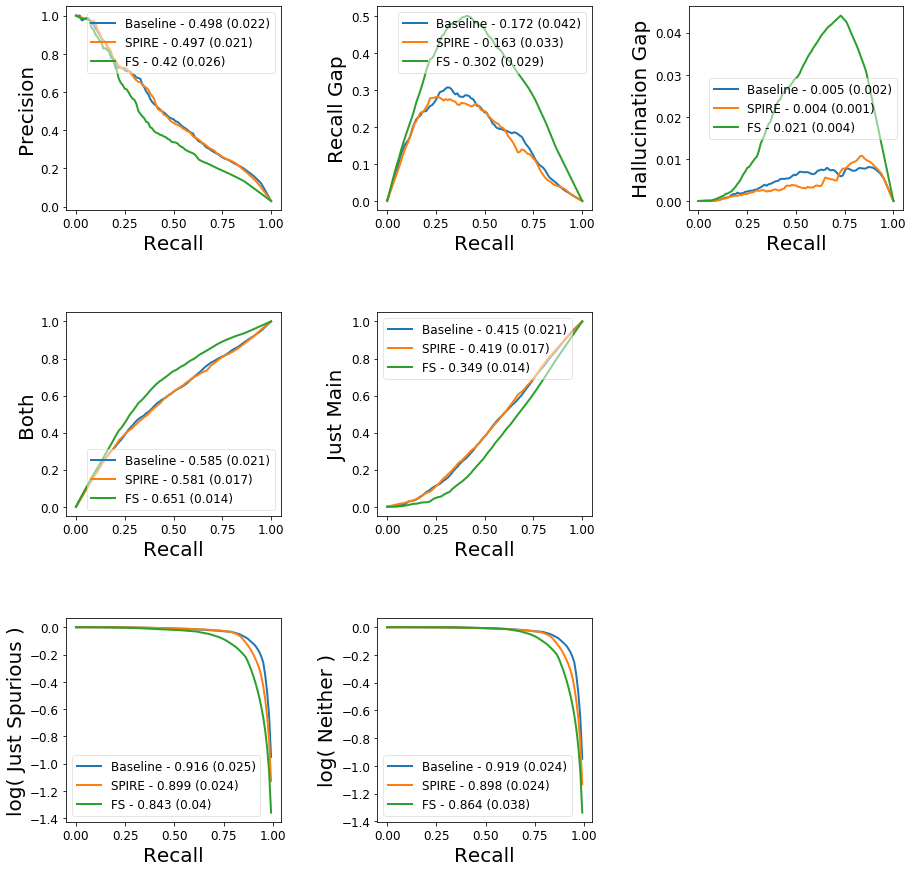

sports+ball-person


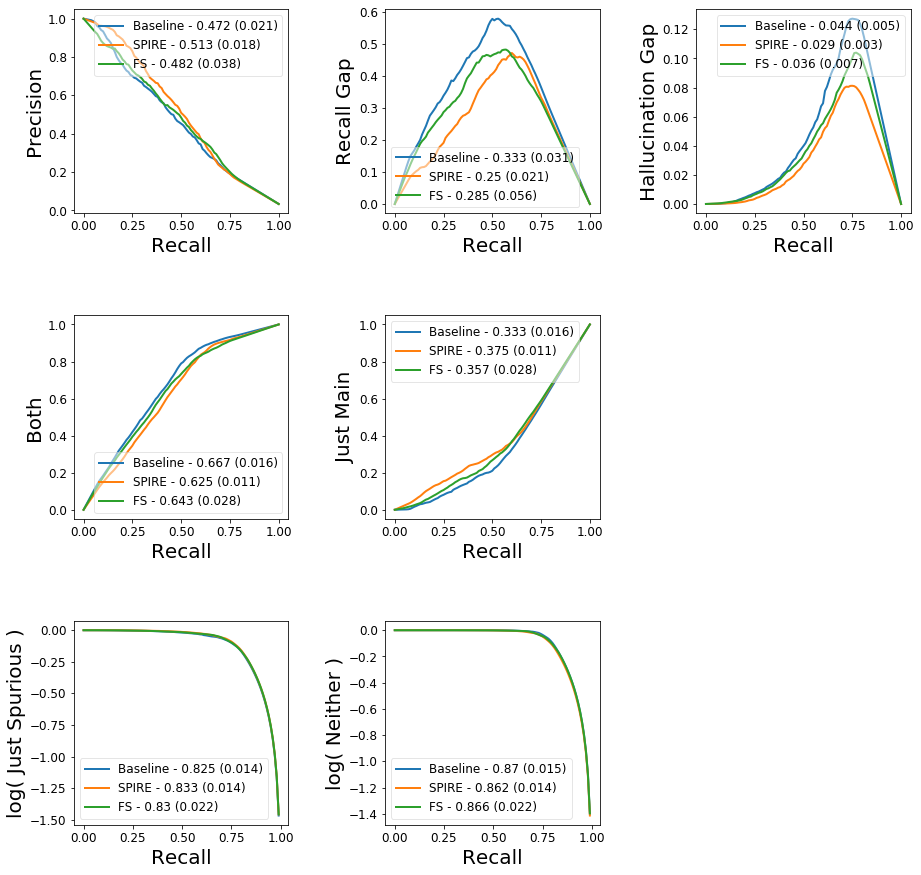

skis-person


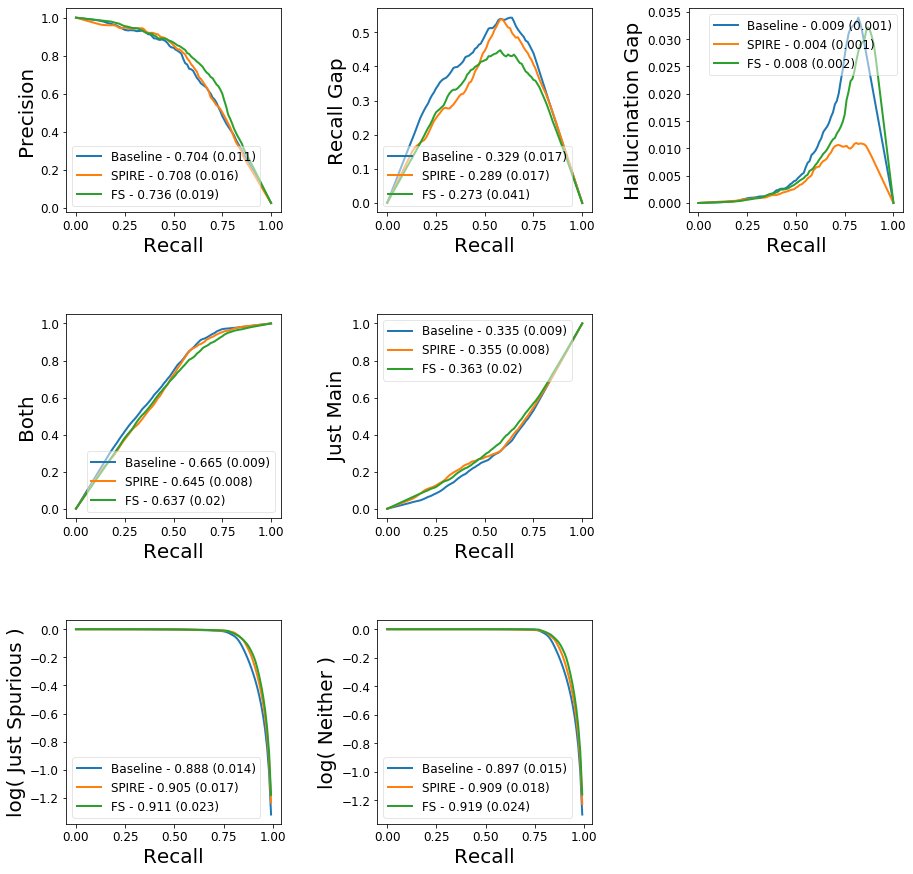

toothbrush-person


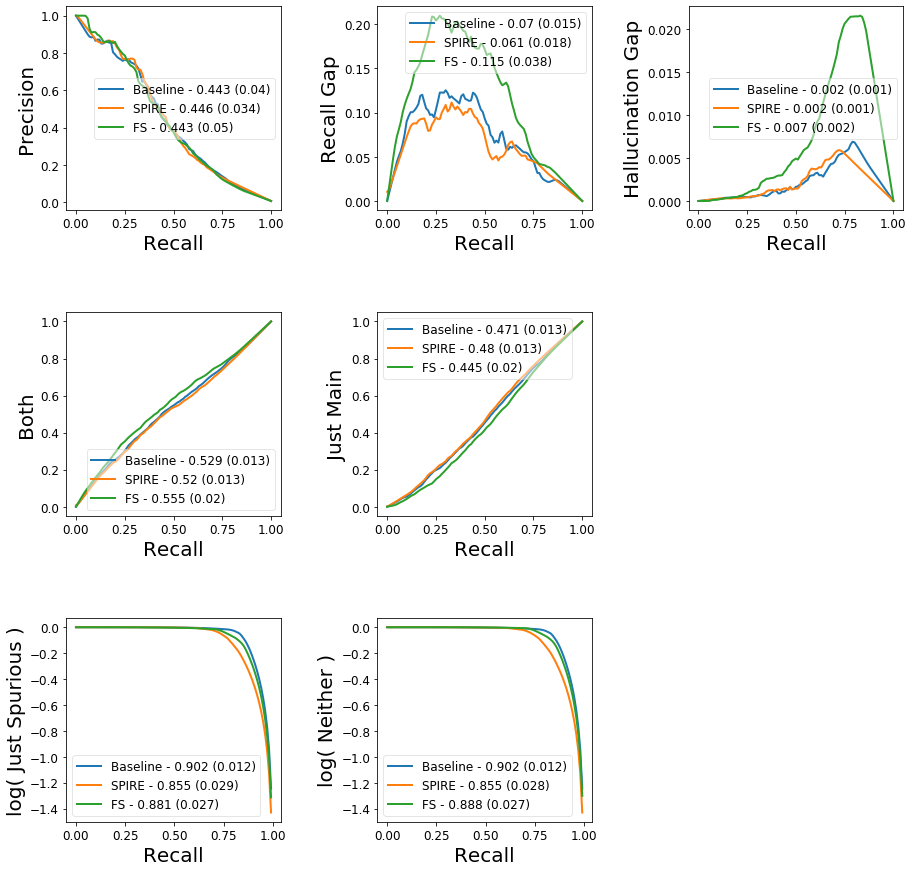

In [5]:

inspect_pair = True
if inspect_pair:
    index_target = 65 # Threshold of 0.5 for the original model gives recall of 65%
    pair_target = 'tennis+racket-person'

show_accs = True
np.seterr(divide = 'ignore') 

mpl.rcParams['font.size'] = 20
mpl.rcParams['lines.linewidth'] = 2
mpl.rcParams['legend.fontsize'] = 12
mpl.rcParams['legend.framealpha'] = 0.5
mpl.rcParams['xtick.labelsize'] = 12
mpl.rcParams['ytick.labelsize'] = 12

ts = np.linspace(0, 1, num = 101)

data = {}
for mode in modes:
    data[mode] = {'ap': [], 'r-gap': [], 'h-gap': [], 'both': [], 'just_main': [], 'just_spurious': [], 'neither': []} 

pr = {}
for mode in modes:
    pr[mode] = []
    
for pair in pairs:
    print(pair)

    if show_accs:
        fig, ax_all = plt.subplots(3, 3)
        fig.set_figheight(15)
        fig.set_figwidth(15)        
    else:
        fig, ax_all = plt.subplots(1, 3)
        fig.set_figheight(5)
        fig.set_figwidth(15)
    fig.subplots_adjust(hspace = 0.5, wspace = 0.45)
    
    for mode in modes:

        values = {'ap': [], 'r-gap': [], 'h-gap': [], 'both': [], 'just_main': [], 'just_spurious': [], 'neither': []} 
        curves = {'ap': [], 'r-gap': [], 'h-gap': [], 'both': [], 'just_main': [], 'just_spurious': [], 'neither': []} 
        for trial in trials:

            with open('./2-Models/Models/{}/trial{}/results.pkl'.format(mode, trial), 'rb') as f:
                results = pickle.load(f)[pair]

            curve_tmp = interpolate(results['recall'], results['precision'], ts)
            curves['ap'].append(curve_tmp)
            values['ap'].append(auc(ts, curve_tmp))
                    
            for name in curves:
                if name != 'ap':
                    curve_tmp = interpolate(results['recall'], results[name], ts)
                    curves[name].append(curve_tmp)
                    values[name].append(auc(ts, curve_tmp))

        values_avg = {}
        values_std = {}
        curves_avg = {}
        for name in values:
            values_avg[name] = np.round(np.mean(values[name]), 3)
            data[mode][name].append(np.mean(values[name]))
            values_std[name] = np.round(np.std(values[name]), 3)
            curves_avg[name] = average_same_x(ts, curves[name])
            
        if inspect_pair and pair == pair_target:
            print()
            print(modes[mode])
            print(0.5 * (results['both'][51] + results['just_main'][51]))

            for name in ['both', 'just_main', 'just_spurious', 'neither', 'r-gap', 'h-gap', 'ap']:
                print(name, np.round(curves_avg[name][index_target], 4))
            print()
        
        pr[mode].append(curves_avg['ap'])
        
        if show_accs:
            ax = ax_all[0,0]
        else:
            ax = ax_all[0]
        ax.plot(ts, curves_avg['ap'], label = '{} - {} ({})'.format(modes[mode], values_avg['ap'], values_std['ap']))
        ax.set_xlabel('Recall')
        ax.set_ylabel('Precision')
        ax.legend()
        
        if show_accs:
            ax = ax_all[0,1]
        else:
            ax = ax_all[1]
        ax.plot(ts, curves_avg['r-gap'], label = '{} - {} ({})'.format(modes[mode], values_avg['r-gap'], values_std['r-gap']))
        ax.set_xlabel('Recall')
        ax.set_ylabel('Recall Gap')
        ax.legend()
        
        if show_accs:
            ax = ax_all[0,2]
        else:
            ax = ax_all[2]
        ax.plot(ts, curves_avg['h-gap'], label = '{} - {} ({})'.format(modes[mode], values_avg['h-gap'], values_std['h-gap']))
        ax.set_xlabel('Recall')
        ax.set_ylabel('Hallucination Gap')
        ax.legend()
        
        if show_accs:
            ax = ax_all[1,0]
            ax.plot(ts, curves_avg['both'], label = '{} - {} ({})'.format(modes[mode], values_avg['both'], values_std['both']))
            ax.set_xlabel('Recall')
            ax.set_ylabel('Both')
            ax.legend()

            ax = ax_all[1,1]
            ax.plot(ts, curves_avg['just_main'], label = '{} - {} ({})'.format(modes[mode], values_avg['just_main'], values_std['just_main']))
            ax.set_xlabel('Recall')
            ax.set_ylabel('Just Main')
            ax.legend()

            ax = ax_all[2,0]
            ax.plot(ts, np.log10(curves_avg['just_spurious']), label = '{} - {} ({})'.format(modes[mode], values_avg['just_spurious'], values_std['just_spurious']))
            ax.set_xlabel('Recall')
            ax.set_ylabel('log( Just Spurious )')
            #ax.set_ylim(bottom = -0.01, top = 0.02)
            ax.legend()

            ax = ax_all[2,1]
            ax.plot(ts, np.log10(curves_avg['neither']), label = '{} - {} ({})'.format(modes[mode], values_avg['neither'], values_std['neither']))
            ax.set_xlabel('Recall')
            ax.set_ylabel('log( Neither )')
            #ax.set_ylim(bottom = -0.01, top = 0.02)
            ax.legend()
            
            ax_all[1,2].set_axis_off()
            ax_all[2,2].set_axis_off()
        
    plt.show()
    plt.close()

np.seterr(divide = 'warn');


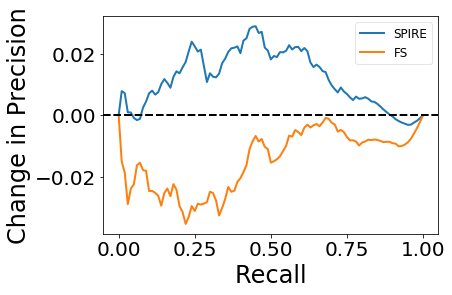

In [6]:
mpl.rcParams['font.size'] = 24
mpl.rcParams['lines.linewidth'] = 2
mpl.rcParams['lines.markersize'] = 12
mpl.rcParams['xtick.labelsize'] = 20
mpl.rcParams['ytick.labelsize'] = 20

for corrected in corrected_list:    
    y_agg_b = np.array(average_same_x(ts, pr[baseline]))
    y_agg_c = np.array(average_same_x(ts, pr[corrected]))
    plt.plot(ts, y_agg_c - y_agg_b, label = modes[corrected])
    plt.axhline(y=0, linestyle='dashed', c = 'black')
plt.legend()
plt.xlabel('Recall')
plt.ylabel('Change in Precision')
    
plt.show()
plt.close()





Mitigation method: SPIRE



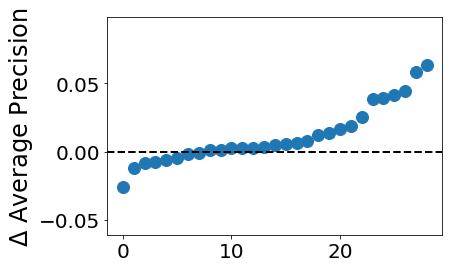

Mean 0.0119
Median 0.0049
Prob > 0 0.7241


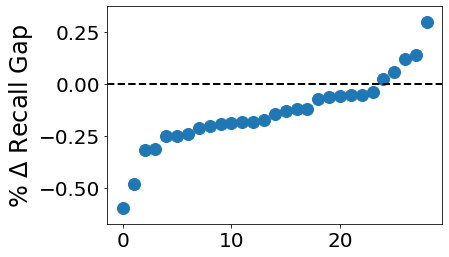

Mean -0.1374
Median -0.1448
Prob < 0 0.8276


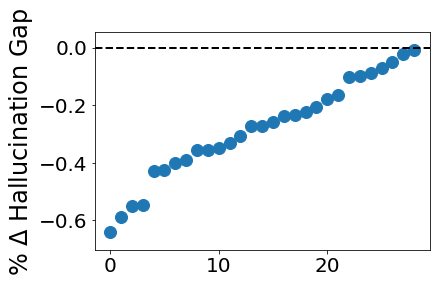

Mean -0.2807
Median -0.2726
Prob < 0 1.0
                  Pair  Change in BAP
          knife-person      -0.025965
      snowboard-person      -0.011672
     hair+drier-person      -0.008013
             dog-sheep      -0.007620
        hot+dog-person      -0.006265
     cell+phone-person      -0.004657
        truck-airplane      -0.001416
         remote-person      -0.000576
 sandwich-dining+table       0.001357
            bird-sheep       0.001589
        handbag-person       0.002850
    spoon-dining+table       0.002920
     toothbrush-person       0.002960
           skis-person       0.003791
 baseball+glove-person       0.004902
          couch-person       0.005773
  tennis+racket-person       0.006135
    knife-dining+table       0.008026
          donut-person       0.011995
        bench-elephant       0.014035
     bowl-dining+table       0.016432
     fork-dining+table       0.019072
        frisbee-person       0.025124
               tie-cat       0.038395
     skat

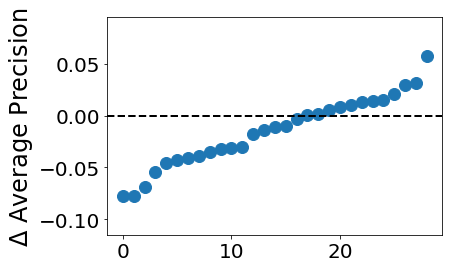

Mean -0.0148
Median -0.0114
Prob > 0 0.4138


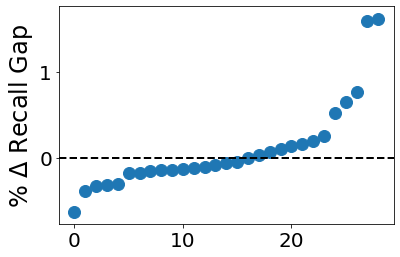

Mean 0.0969
Median -0.0592
Prob < 0 0.5862


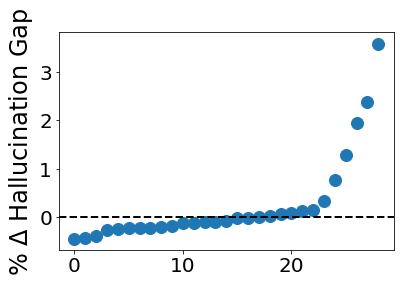

Mean 0.2574
Median -0.0687
Prob < 0 0.5862
                  Pair  Change in BAP
         remote-person      -0.078009
     cell+phone-person      -0.077885
     hair+drier-person      -0.069195
             dog-sheep      -0.054053
          knife-person      -0.045657
          couch-person      -0.042759
 sandwich-dining+table      -0.040851
            bird-sheep      -0.039532
     fork-dining+table      -0.035475
        truck-airplane      -0.032505
    knife-dining+table      -0.031016
        hot+dog-person      -0.030318
          donut-person      -0.018195
    spoon-dining+table      -0.014005
        bench-elephant      -0.011365
        handbag-person      -0.010451
               tie-cat      -0.002979
     toothbrush-person       0.000798
     skateboard-person       0.001554
      snowboard-person       0.005249
  tennis+racket-person       0.008171
    sports+ball-person       0.010232
            tie-person       0.012747
   baseball+bat-person       0.013665
       

In [7]:

mpl.rcParams['font.size'] = 24
mpl.rcParams['lines.linewidth'] = 2
mpl.rcParams['lines.markersize'] = 12
mpl.rcParams['xtick.labelsize'] = 20
mpl.rcParams['ytick.labelsize'] = 20

for corrected in corrected_list:
    print()
    print()
    print()
    print('Mitigation method:', modes[corrected])
    print()
    
    for config in  [('ap', 'Average Precision')]:
        v = np.array(data[corrected][config[0]]) - np.array(data[baseline][config[0]])
        
        v_sort = np.sort(v)
        
        plt.scatter(np.arange(len(v_sort)), v_sort)
        plt.axhline(y=0, linestyle='dashed', c = 'black')
        plt.ylabel("$\Delta$ {}".format(config[1]))
        plt.show()
        plt.close()      
        
        print('Mean',  np.round(np.mean(v), 4))
        print('Median', np.round(np.median(v), 4))
        print('Prob > 0', np.round(np.mean(v > 0), 4))


    for config in [('r-gap', 'Recall Gap'), ('h-gap', 'Hallucination Gap')]:
        
        metric = config[0]
        metric_name = config[1]
        
        x = np.array(data[corrected][metric])
        y = np.array(data[baseline][metric])
        
        v = (x - y) / y
        
        v_sort = np.sort(v)
        
        plt.scatter(np.arange(len(v_sort)), v_sort)
        plt.axhline(y=0, linestyle='dashed', c = 'black')
        plt.ylabel("% $\Delta$ {}".format(metric_name))
        plt.show()
        plt.close()

        print('Mean',  np.round(np.mean(v), 4))
        print('Median', np.round(np.median(v), 4))
        print('Prob < 0', np.round(np.mean(v < 0), 4))

    data_df = []

    diffs = np.array(data[corrected]['ap']) - np.array(data[baseline]['ap'])

    for i, pair in enumerate(pairs):
        data_df.append([pair, diffs[i]])

    df = pd.DataFrame(data_df, columns = ['Pair', 'Change in BAP'])

    df = df.sort_values('Change in BAP')

    print(df.to_string(index = False))
 